In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import meshio
import os
import time
from scipy.interpolate import griddata
from sklearn.model_selection import train_test_split
from tensorflow import keras


warnings.filterwarnings('ignore')
%matplotlib inline
import tensorflow as tf


# Loading Dataset

In [2]:
x = np.arange(0.006, 0.0135, (0.0135-0.006)/300)
y = np.arange(0, 0.0025, 0.0025/75)

data_path = './Data'
path_sep = '\\' # use '/' for Unix and '\\' for Windows
folders = os.listdir(data_path)
        
subfolder = []
path = []
names = []
condition = []

for i in folders:
    if os.path.isdir(data_path + path_sep + i): 
        subfolder.append(data_path + path_sep + i)

for folder in subfolder:
    files = os.listdir(folder + path_sep)
    for i in files:
        ext = os.path.splitext(i)
        if (ext[-1].lower() == '.vtk') & (ext[0][-2] != '_'):
            names.append(ext[0])
            string = ext[0].replace('ER', '').replace('Tin', '').replace('Uin', '').replace('Twall', '').split('_')[0:4]
            var = []
            for j in string:
                if j == 'Adiabatic':
                    var.append(0.)
                else:
                    var.append(float(j))
            condition.append(var)

Q_list = []
for folder in subfolder:
    files = os.listdir(folder + path_sep)
    for counter,file in enumerate(files):
        mesh = meshio.read(folder+ path_sep +file)
        points = mesh.points
        Qdot = mesh.point_data['Qdot']
        boolArr = (points[:,1] == 0) & (points[:,0] >= 0.006)  
        Qdot = Qdot[boolArr]
        points = points[boolArr]
        old_points = points[:,[0, 2]]
        grid_x, grid_y = np.meshgrid(x, y)
        grid_new = griddata(old_points, Qdot, (grid_x, grid_y), method='nearest')
        Q_list.append(grid_new)
Q_list

# Data Preparation

In [3]:
Qdot = np.array(Q_list)
Qdot = Qdot / np.max(Qdot)
mean = Qdot.mean(axis = 0)
Qdot = np.reshape(Qdot, (-1, 75, 300, 1))

normaliser = []
conditions = np.array(condition)
df = np.zeros(conditions.shape)
for i in range(conditions.shape[1]):
    df[:,i] = conditions[:,i] / np.max(conditions[:,i])
    normaliser.append(np.max(conditions[:,i]))

train_data, test_data, label_train, label_test = train_test_split(Qdot, df, test_size = 0.15)
print(train_data.shape)
print(df.shape)

# Manual train test split if needed
#test_index = 

#train_index = 

#test_data = Qdot[test_index]
#train_data = Qdot[train_index]
#label_train = df[train_index]
#label_test = df[test_index]

(203, 75, 300, 1)
(239, 4)


In [4]:
print(normaliser)
# df
# Equivalence ratio (1)
# Temperature (460)
# Velocity (0.50 m/s)
# Wall Temperature (373 or None)

[1000.0, 460.0, 50.0, 373.0]


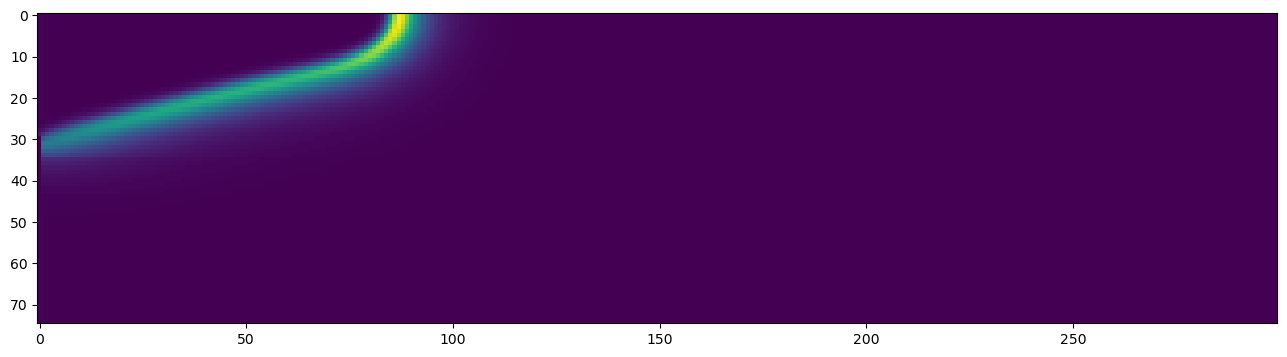

In [5]:
fig = plt.figure(figsize=(16, 80))
plt.imshow(np.reshape(Qdot[3],(75, 300)))
# plt.axis('off')
# image = next(iter(Qdot))
# image


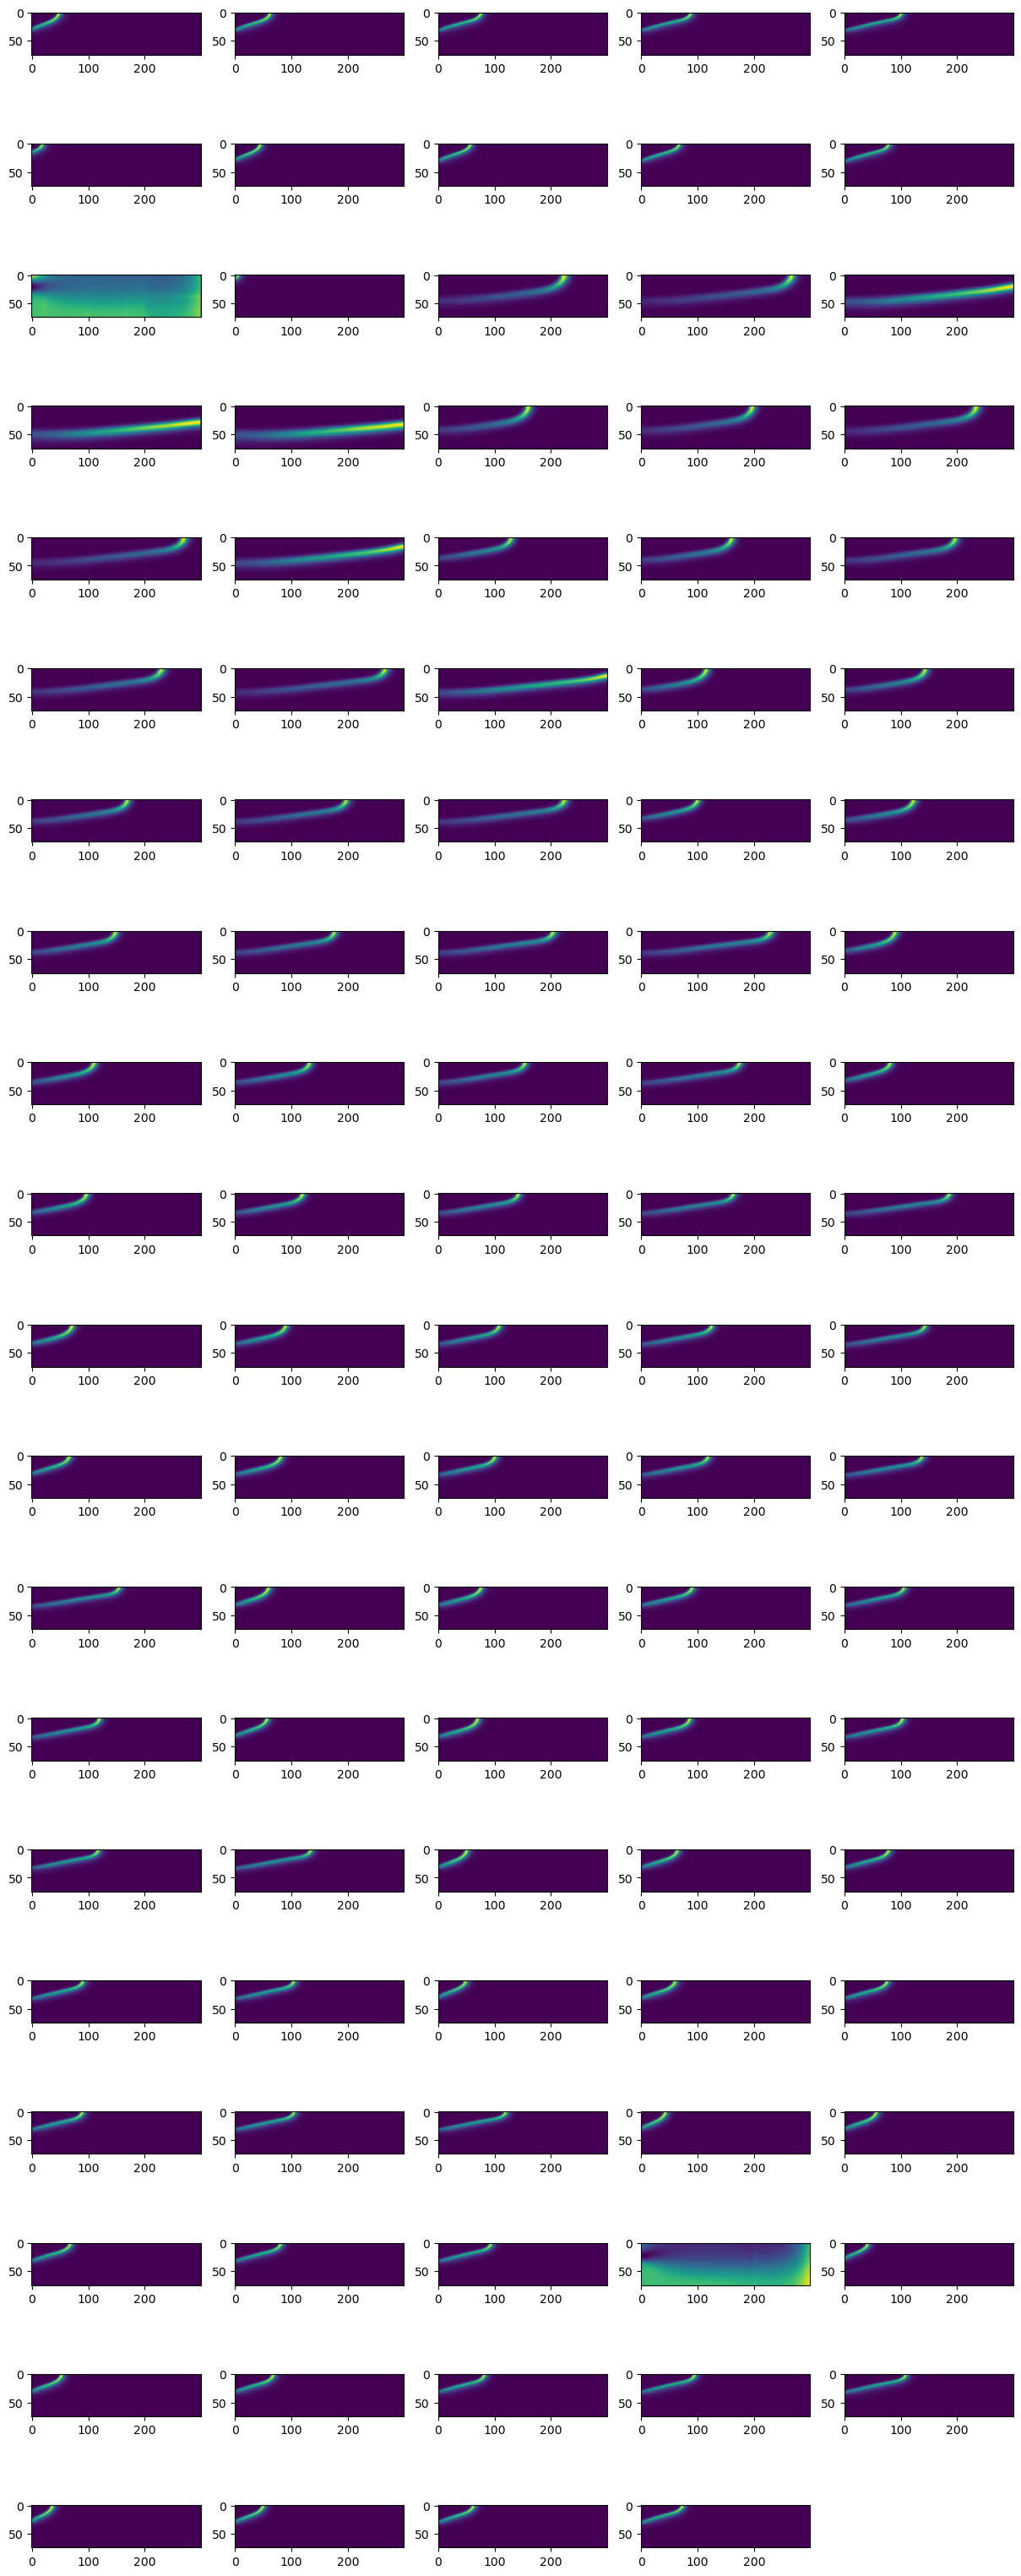

In [6]:
fig = plt.figure(figsize=(15, 40))
columns = 5
rows = 20

for i in range(1, columns * rows):
    img = Qdot[(i-1)]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()



## Convolutional Autoencoder
### Encoder Part

In [ ]:
model =tf.keras.Sequential([
        # Input layer 
        tf.keras.layers.InputLayer(input_shape = (75,300,1)),
        
        # Conv layer + BatchNom + LeakyReLU + MaxPooling
        tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        
        tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=3, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        # Conv layer + BatchNom + LeakyReLU + MaxPooling
        tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=5,padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.MaxPooling2D(pool_size=(5, 5)),
        
        # Flatten  
        tf.keras.layers.Flatten(),
        
        # Fully NN --> Laten variables
        tf.keras.layers.Dense(latent_dim)
    ])

model.summary()

In [26]:
model = tf.keras.Sequential([
                tf.keras.layers.InputLayer(input_shape = (latent_dim,)),
                
                # Fully NN 
                tf.keras.layers.Dense(units = 1*4*64),
                tf.keras.layers.Reshape(target_shape = (1,4,64)),
                
                # Conv layer 
                tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=5, strides=5,padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.LeakyReLU(),
                
                # Conv layer  
                tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=5, strides=5,padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.LeakyReLU(),
                
                # Conv layer 
                tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=3, padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Activation('sigmoid')
                ])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               1280      
                                                                 
 reshape_2 (Reshape)         (None, 1, 4, 64)          0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 5, 20, 64)         102464    
 Transpose)                                                      
                                                                 
 batch_normalization_12 (Ba  (None, 5, 20, 64)         256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 5, 20, 64)         0         
                                                                 
 conv2d_transpose_7 (Conv2D  (None, 25, 100, 32)      

In [30]:
class Autoencoder(tf.keras.Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    
    self.encoder = tf.keras.Sequential([
        # Input layer 
        tf.keras.layers.InputLayer(input_shape = (75,300,1)),
        
        # Conv layer + BatchNom + LeakyReLU + MaxPooling
        tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        # tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
        
        tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=3, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        # Conv layer + BatchNom + LeakyReLU + MaxPooling
        tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=5,padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.MaxPooling2D(pool_size=(5, 5)),
        
        # Flatten  
        tf.keras.layers.Flatten(),
        
        # Fully NN --> Laten variables
        tf.keras.layers.Dense(latent_dim)
    ])
    
    self.decoder = tf.keras.Sequential([
                tf.keras.layers.InputLayer(input_shape = (latent_dim,)),
                
                # Fully NN 
                tf.keras.layers.Dense(units = 1*4*64),
                tf.keras.layers.Reshape(target_shape = (1,4,64)),
                
                # Conv layer 
                tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=3,padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.LeakyReLU(),
                
                # Conv layer  
                tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=5, strides=5,padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.LeakyReLU(),
                
                # Conv layer 
                tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=5, strides=5, padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.LeakyReLU()
                ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


latent_dim = 8
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss='mse')

In [31]:
# def ae_loss(y_true, y_pred):
#     loss = tf.keras.losses.mean_squared_error(y_true,y_pred)
#     return loss

hist = autoencoder.fit(train_data, train_data,
                epochs=100,
                batch_size = 8,
                validation_data=(test_data, test_data))

Epoch 1/100
26/26 [==============================] - 5s 92ms/step - loss: 0.2050 - val_loss: 0.0021
Epoch 2/100
26/26 [==============================] - 2s 80ms/step - loss: 0.0962 - val_loss: 0.0021
Epoch 3/100
26/26 [==============================] - 2s 82ms/step - loss: 0.0873 - val_loss: 0.0021
Epoch 4/100
26/26 [==============================] - 2s 82ms/step - loss: 0.0838 - val_loss: 0.0021
Epoch 5/100
26/26 [==============================] - 2s 72ms/step - loss: 0.0801 - val_loss: 0.0021
Epoch 6/100
26/26 [==============================] - 2s 71ms/step - loss: 0.0768 - val_loss: 0.0021
Epoch 7/100
26/26 [==============================] - 2s 72ms/step - loss: 0.0739 - val_loss: 0.0021
Epoch 8/100
26/26 [==============================] - 2s 72ms/step - loss: 0.0710 - val_loss: 0.0021
Epoch 9/100
26/26 [==============================] - 2s 77ms/step - loss: 0.0681 - val_loss: 0.0021
Epoch 10/100
26/26 [==============================] - 2s 72ms/step - loss: 0.0652 - val_loss: 0.0022

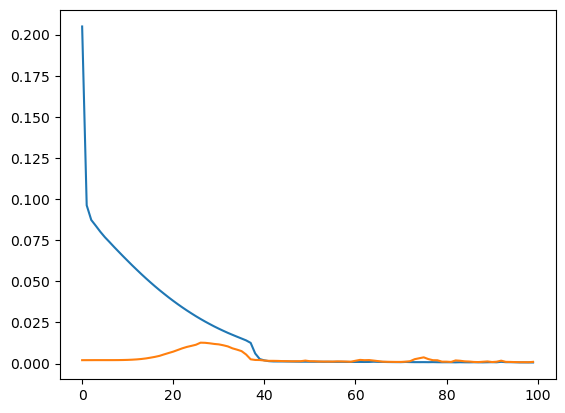

In [32]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.plot(loss)
plt.plot(val_loss)

In [33]:
encoded_imgs = autoencoder.encoder(test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

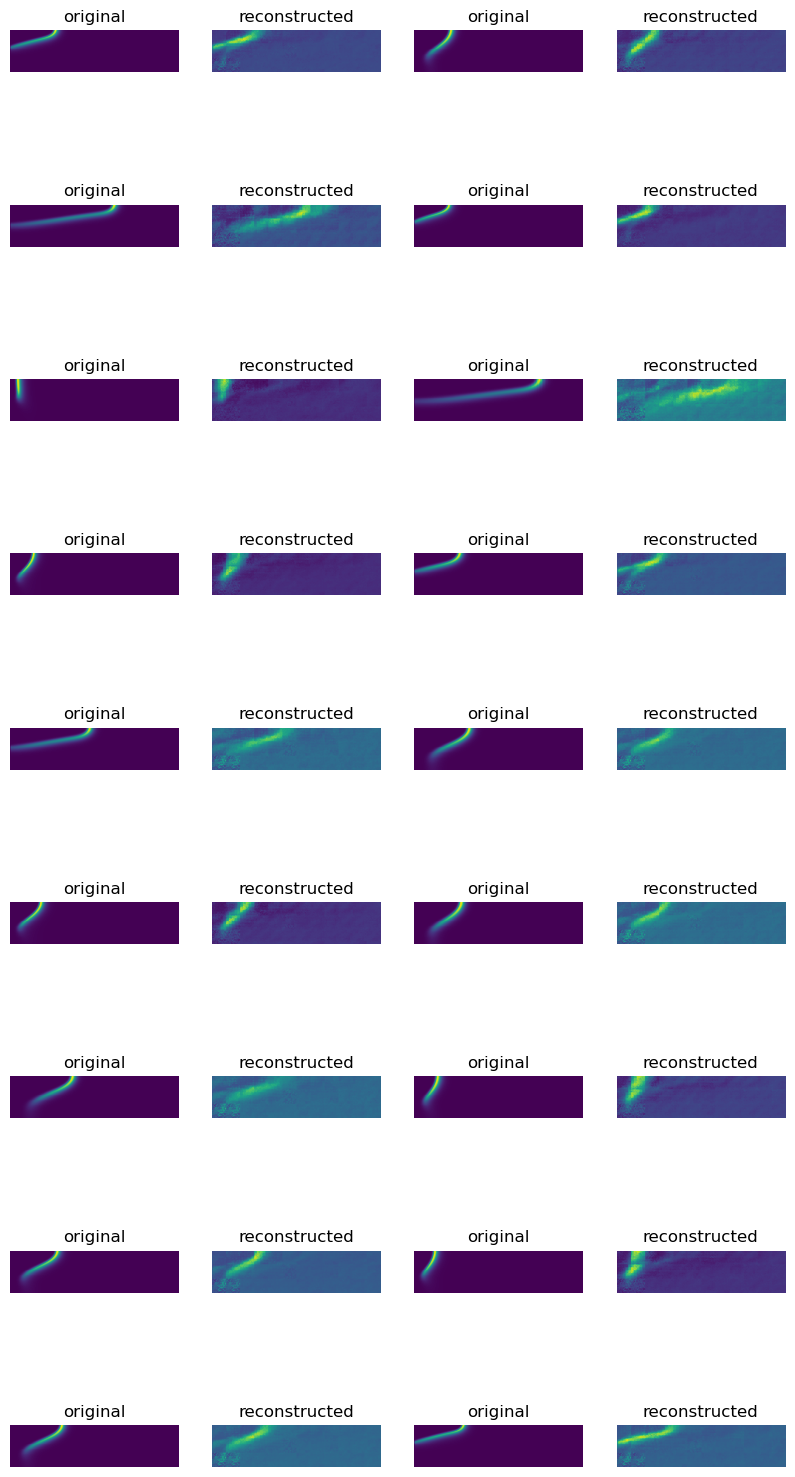

In [43]:
fig = plt.figure(figsize=(10, 20))
columns = 4
rows = 9
for i in range(1, columns * rows + 1, 2):

    img = test_data[i - 1] 
    ax = fig.add_subplot(rows, columns, i)  
    plt.imshow(img)
    plt.title("original")
    plt.axis('off')  

    decoded_img = decoded_imgs[i - 1]  
    ax = fig.add_subplot(rows, columns, i + 1) 
    plt.imshow(decoded_img)
    plt.title("reconstructed")
    plt.axis('off')  

plt.show()

In [ ]:
fig = plt.figure(figsize=(15, 40))
columns = 5
rows = 20

for i in range(1, columns * rows):
    img = Qdot[(i-1)]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [ ]:
decoer = tf.keras.Sequential([
                tf.keras.layers.InputLayer(input_shape = (latent_dim,)),
                
                # Fully NN 
                tf.keras.layers.Dense(units = 1*4*64),
                tf.keras.layers.Reshape(target_shape = (1,4,64)),
                
                # Conv layer 
                tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=5, strides=5,padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.LeakyReLU(),
                
                # Conv layer  
                tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=5, strides=5,padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.LeakyReLU(),
                
                # Conv layer 
                tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=3, padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Activation('sigmoid')
                ])

decoder.summary()


In [60]:
# optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

# def ae_loss(y_true, y_pred):
#     loss = tf.keras.losses.mean_squared_error(y_true,y_pred)
#     return loss

In [ ]:
# # @tf.function
# # def train_step(images):

# #     with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
      
# #         latent = enc(images, training=True)
# #         generated_images = dec(latent, training=True)
# #         loss = ae_loss(images, generated_images)
        
# #     gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
# #     gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)
    
    
# #     optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
# #     optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
# #     return loss

# def cae(dataset, epochs):
#   latent = enc(dataset)
#   pre_images = dec(latent)
  
#   for epoch in range(epochs):
#     start = time.time()
#     for image_batch in dataset:
#       train_step(image_batch)
 
#     print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


# train(train_data, epochs = 50)